# Quality evaluation synthetic data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

In [2]:
module_path = os.path.abspath(os.path.join('../../evaluation_metrics'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Load data

In [3]:
# Static data frames
original_static = pd.read_pickle('../../../../Master Thesis/data/preprocessed/tumours_patients_2017_train.pickle').set_index('eid').astype(str)
PBSeps1_static = pd.read_pickle('./synthetic_data/PBS_eps1_tumours.pickle').astype(str)
PBSeps01_static = pd.read_pickle('./synthetic_data/PBS_eps0.1_tumours.pickle').astype(str)

In [4]:
# Treatments data frames
original_treatments = pd.read_pickle('../../../../Master Thesis/data/preprocessed/treatments_2017_train.pickle')
PBSeps1_treatments = pd.read_pickle('./synthetic_data/PBS_eps1_treatments.pickle')
PBSeps01_treatments = pd.read_pickle('./synthetic_data/PBS_eps0.1_treatments.pickle')

In [5]:
# Test data
original_test_static = pd.read_pickle('../../../../Master Thesis/data/preprocessed/tumours_patients_2017_test.pickle').set_index('eid').astype(str)
original_test_treatments = pd.read_pickle('../../../../Master Thesis/data/preprocessed/treatments_2017_test.pickle')

In [6]:
# th_gebeurtenis -> translation to main groups
th_gebeurtenis = pd.read_csv('../../../../Master Thesis/data/thesauri/th_gebeurtenis.csv', engine='python')

def _change_stoma_hoofdgroep(row):
    if 'stoma' in row['omschrijving'].lower():
        return 'STOMA'
    else:
        return row['hoofdgroep_code']

th_gebeurtenis['hoofdgroep_code'] = th_gebeurtenis.apply(lambda row: _change_stoma_hoofdgroep(row), axis=1)
maingroup_dict = dict(zip(th_gebeurtenis['code'], th_gebeurtenis['hoofdgroep_code']))

In [7]:
def _change_stoma_hoofdgroep_oms(row):
    if 'stoma' in row['omschrijving'].lower():
        return 'STOMA'
    else:
        return row['hoofdgroep_omschrijving']

th_gebeurtenis['hoofdgroep_omschrijving'] = th_gebeurtenis.apply(lambda row: _change_stoma_hoofdgroep_oms(row), axis=1)

In [8]:
# Original treatments to main group
# Train
original_treatments['gbs_gebeurtenis_code'] = original_treatments['gbs_gebeurtenis_code'].replace(maingroup_dict)
# Test
original_test_treatments['gbs_gebeurtenis_code'] = original_test_treatments['gbs_gebeurtenis_code'].replace(maingroup_dict)

In [9]:
for_maingroup_dict = th_gebeurtenis[th_gebeurtenis['hoofdgroep_code']!=th_gebeurtenis['hoofdgroep_omschrijving']]

# Create maingroup dict (with Hoofdgroep code to Hoofdgroep code as data is already binned per main group)
maingroup_dict = dict(zip(for_maingroup_dict['hoofdgroep_code'], for_maingroup_dict['hoofdgroep_code']))
maingroup_dict['STOMA'] = 'STOMA'

In [10]:
synth_static = {
    'PBS ' + r'$\varepsilon=1$': PBSeps1_static, 
    'PBS ' + r'$\varepsilon=0.1$': PBSeps01_static, 
}

synth_treatments = {
    'PBS ' + r'$\varepsilon=1$': PBSeps1_treatments, 
    'PBS ' + r'$\varepsilon=0.1$': PBSeps01_treatments, 
}

In [11]:
feature_rename_dict = {'tum_topo_code': 'Topology code',
                       'pat_geslacht_code': 'Gender',
                       'tum_differentiatiegraad_code': 'Differentiation grade',
                       'tum_lymfklieren_positief_atl': 'Nr positive lymph nodes', 
                       'age_at_diagnosis': 'Age at diagnosis',
                       'tum_topo_sublokalisatie_code': 'Sublocation',
                       'stadium': 'Stage',
                       'survival_1': '1 year survival',
                       'gbs_gebeurtenis_code': 'Sequence length'}

## QualityEvaluator

In [12]:
from evaluator import QualityEvaluator

In [13]:
qe = QualityEvaluator(original_static, original_treatments, original_test_static, original_test_treatments,
                      maingroup_dict, synth_static, synth_treatments, feature_rename_dict=feature_rename_dict)

### Metric 1: Patient covariates

{'PBS $\\varepsilon=1$': 0.028359591569320008,
 'PBS $\\varepsilon=0.1$': 0.048511037656010836}

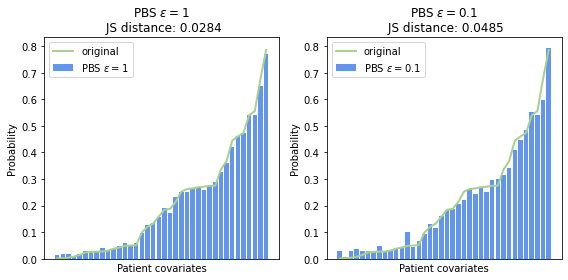

In [14]:
qe.m1_JSdistance_covariates(visual=True)

### Metric 2: RMSE treatment occurrence percentages

{'PBS $\\varepsilon=1$': 0.020656948192998657,
 'PBS $\\varepsilon=0.1$': 0.07236820197977739}

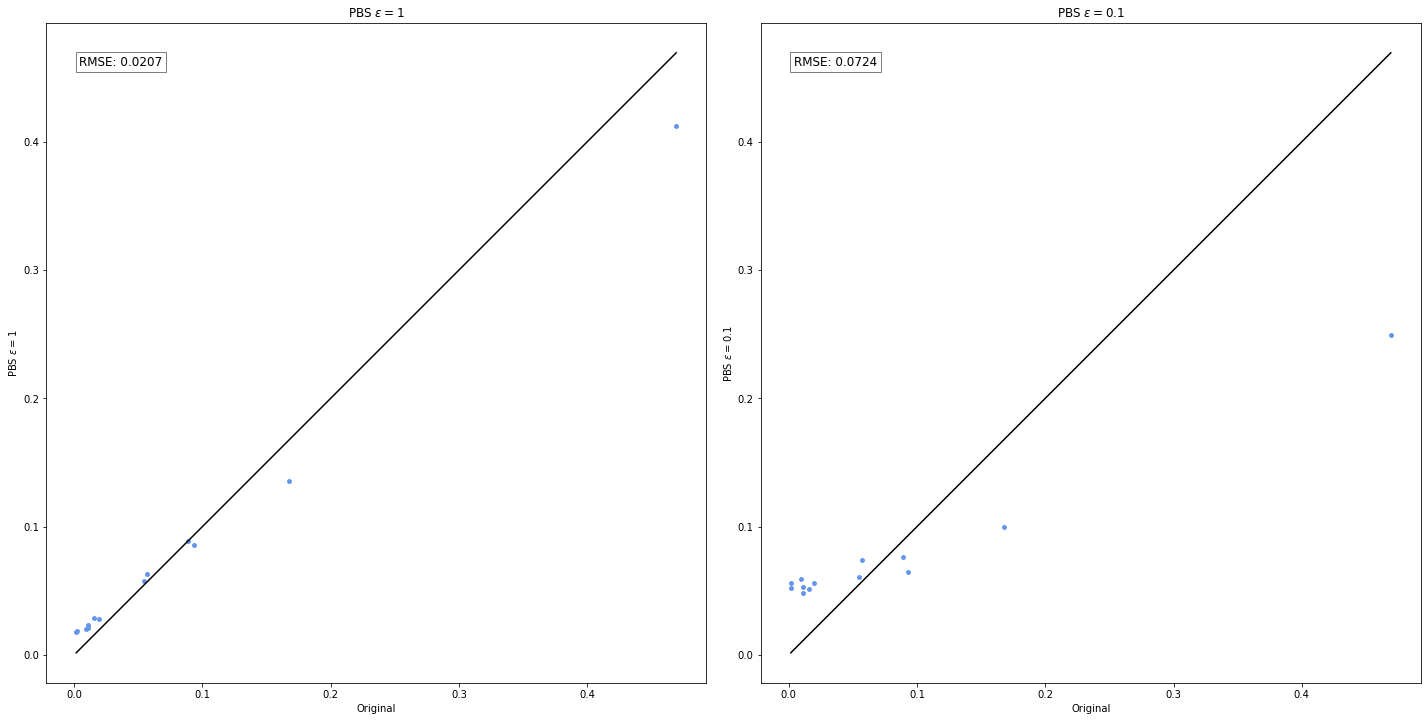

In [15]:
qe.m2_RMSE_treatment_occurrences(visual=True)

{'PBS $\\varepsilon=1$': 0.9984522646393672,
 'PBS $\\varepsilon=0.1$': 0.9847746199993043}

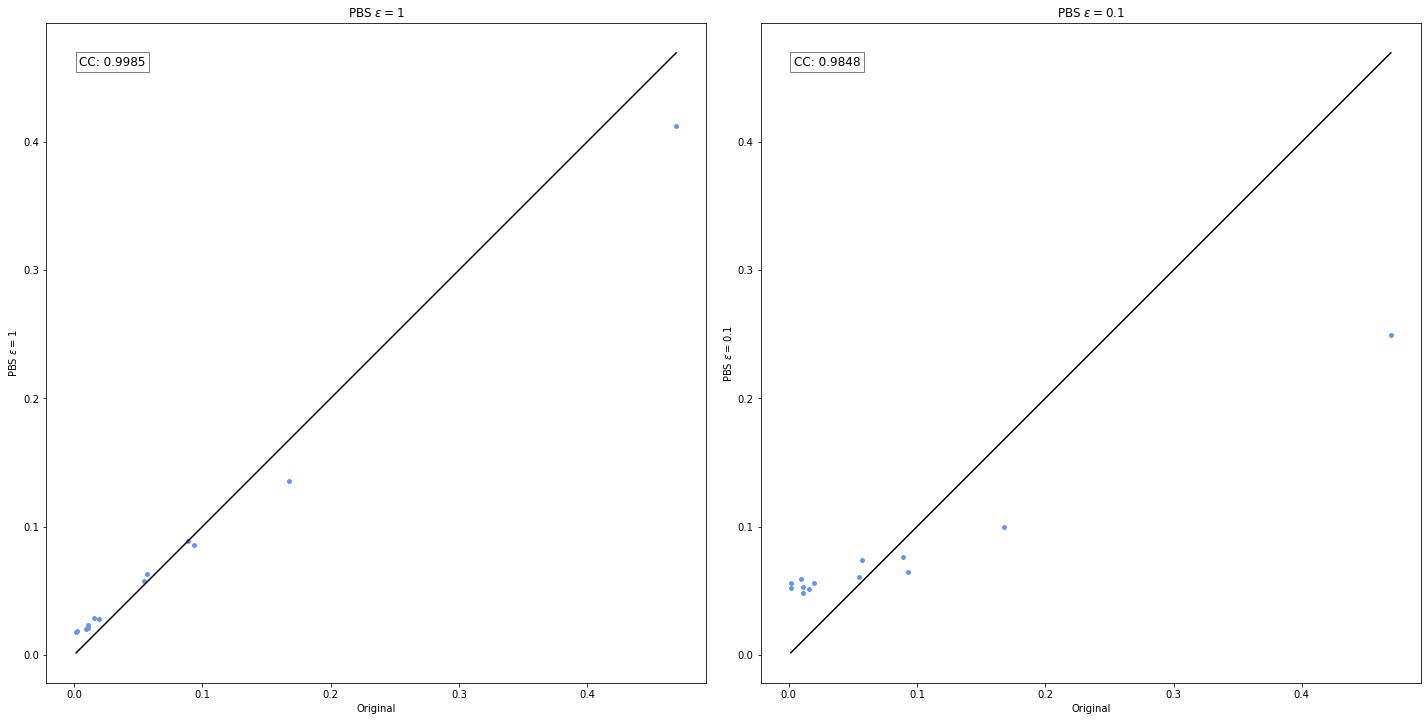

In [16]:
qe.m2_RMSE_treatment_occurrences(visual=True, metric='CC')

### Metric 3: Support Coverage treatments

In [17]:
qe.m3_SC_treatments()

{'PBS $\\varepsilon=1$': 1.0, 'PBS $\\varepsilon=0.1$': 1.0}

### Metric 4: JS distance sequence lengths

{'PBS $\\varepsilon=1$': 0.02971408693379417,
 'PBS $\\varepsilon=0.1$': 0.06418746442166309}

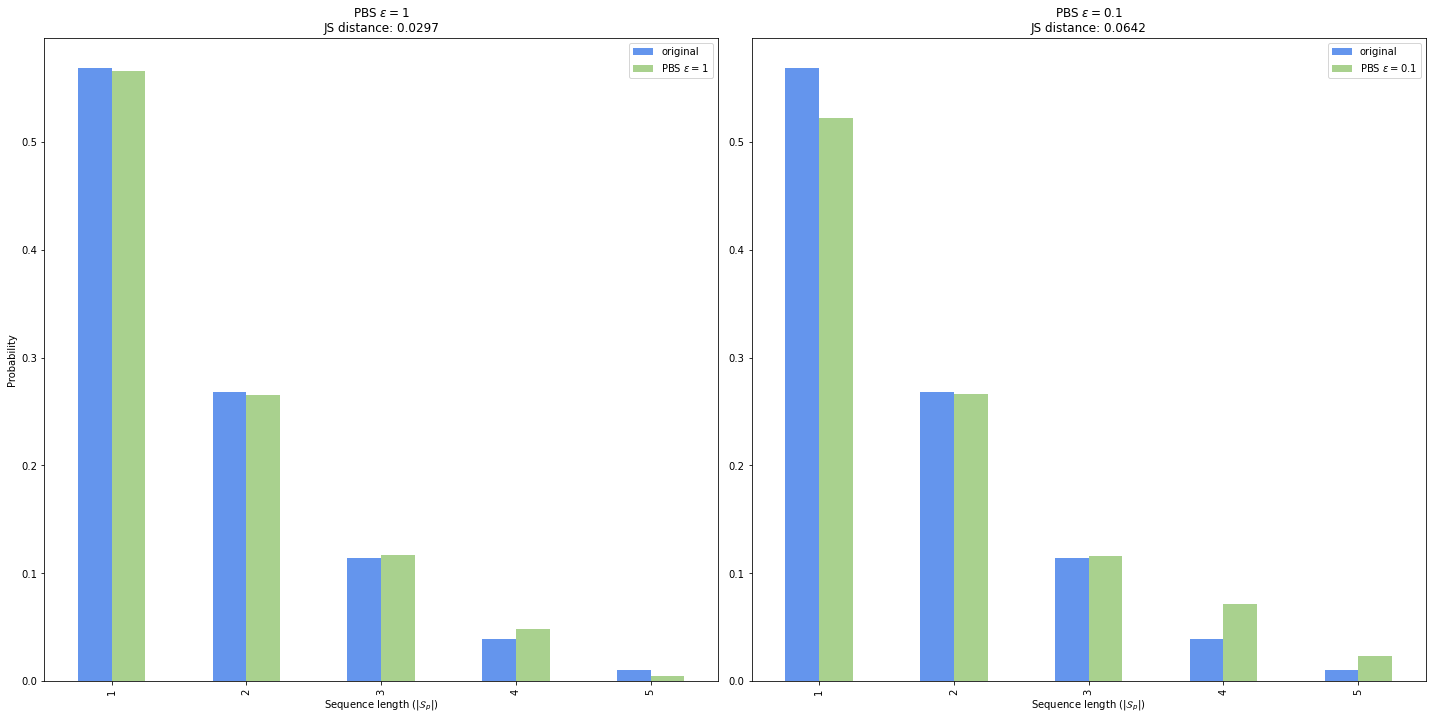

In [18]:
qe.m4_JSdistance_sequence_lengths(visual=True)

### Metric 5: Associations (PCD)

In [19]:
nominal_columns = list(set(original_static.columns) - set(['pat_geslacht_code', 'survival_1']))

In [20]:
nominal_columns = [feature_rename_dict[col] for col in nominal_columns]

{'PBS $\\varepsilon=1$': {'total': 1.5594150108589835,
  'static': 0.3268684209865159,
  'static_treatments': 0.8249829998745035,
  'treatments': 0.9817017425319334},
 'PBS $\\varepsilon=0.1$': {'total': 2.6886749744295972,
  'static': 0.3680883138500109,
  'static_treatments': 1.4552955594356085,
  'treatments': 1.6904773824884645}}

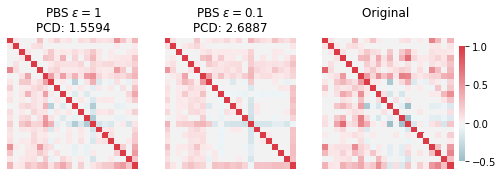

In [21]:
qe.m5_PCD(nominal_columns=nominal_columns, visual=True)

{'PBS $\\varepsilon=1$': {'total': 1.5594150108589835,
  'static': 0.3268684209865159,
  'static_treatments': 0.8249829998745035,
  'treatments': 0.9817017425319334},
 'PBS $\\varepsilon=0.1$': {'total': 2.6886749744295972,
  'static': 0.3680883138500109,
  'static_treatments': 1.4552955594356085,
  'treatments': 1.6904773824884645}}

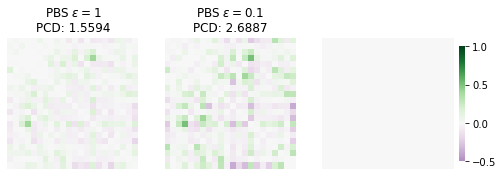

In [22]:
qe.m5_PCD(nominal_columns=nominal_columns, visual_difference=True)

### Metric 6: TB-TOH

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 14.9min finished


Finished training model on original train set
Finished training model on PBS $\varepsilon=1$
Finished training model on PBS $\varepsilon=0.1$


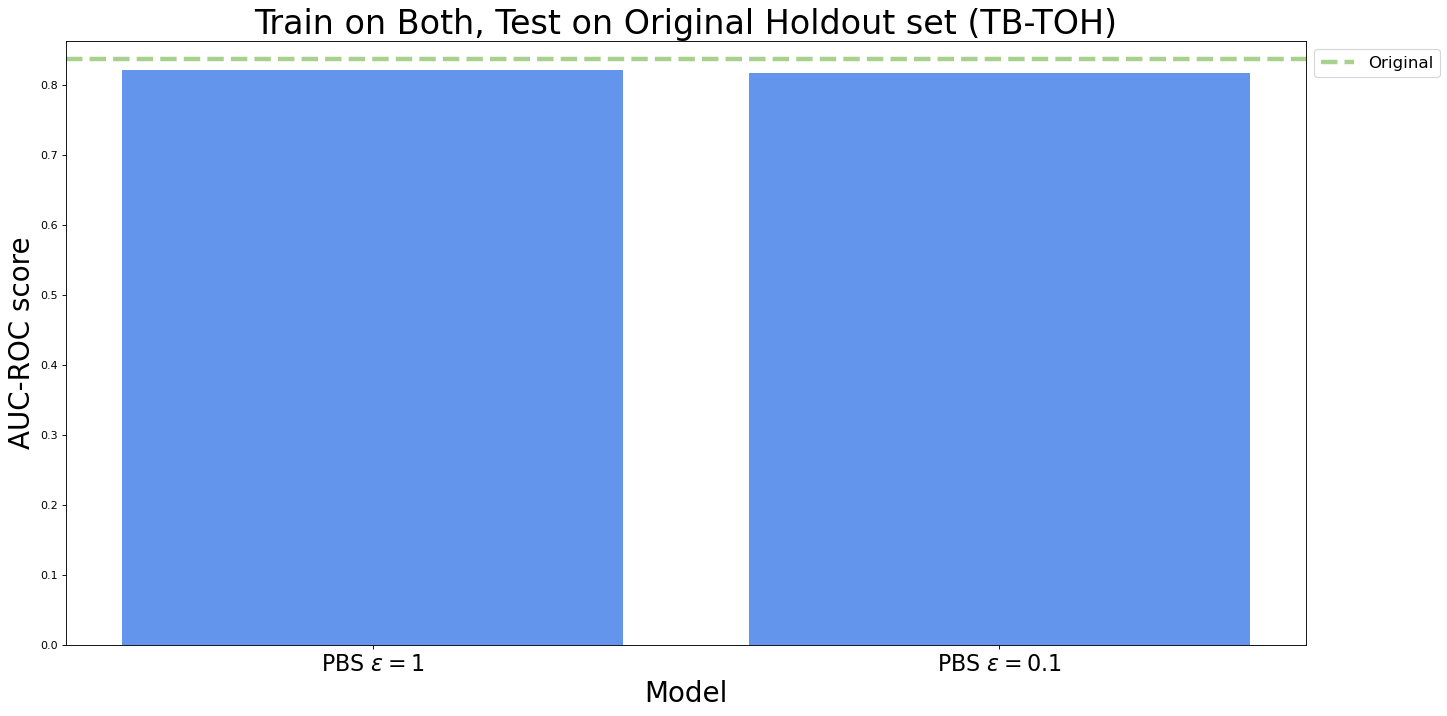

{'original': 0.8368029051156998,
 'PBS $\\varepsilon=1$': {'auc': 0.822073582796046,
  'TB_TOH': 0.9823980984893722},
 'PBS $\\varepsilon=0.1$': {'auc': 0.8164586870411881,
  'TB_TOH': 0.9756881603181112}}

In [23]:
qe.m6_TBTOH(n_jobs=-1, feature_importances=True, visual=True)

#### Additional check to see what features models rely on

In [25]:
def plot_feature_importance(importance, names, dataset): 

    #Create arrays from feature importance and feature names 
    feature_importance = np.array(importance) 
    feature_names = np.array(names) 

    #Create a DataFrame using a Dictionary 
    data={'feature_names': feature_names, 'feature_importance': feature_importance} 
    fi_df = pd.DataFrame(data) 

    #Sort the DataFrame in order decreasing feature importance 
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot 
    plt.figure(figsize=(10,8)) 
    #Plot Searborn bar chart 
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names']) 
    #Add chart labels
    plt.title('Feature importance model trained on {} for 1-year survival prediction'.format(dataset))
    plt.xlim(0)
    plt.xlabel('Feature importance') 
    plt.ylabel('Feature name') 

In [26]:
features = ['Topology code', 'Gender', 'Differentiation grade',
            'Nr positive lymph nodes', 'Age at diagnosis', 'Sublocation', 'Stage',
            'CHEMOTHERAPIE', 'CHEMORADIATIE', 'LOKALE CHEMOTHERAPIE EN IMMUNOTHERAPIE', 'LOKALE CHIRURGIE',
            'CHIRURGIE GERICHT OP METASTASEN', 'ORGAAN CHIRURGIE', 'OVERIGE CHIRURGIE', 'GEEN ACTIEVE BEHANDELING',
            'OVERIGE BEHANDELINGEN', 'RADIOTHERAPIE GERICHT OP PRIMAIRE LOKALISATIE', 'RADIOTHERAPIE GERICHT OP METASTASEN',
            'STOMA', 'TARGETED THERAPIE', 'Sequence length']

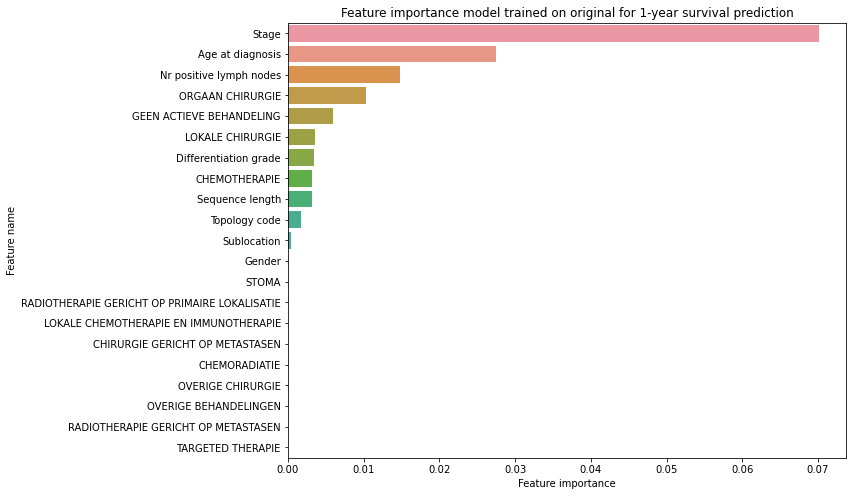

In [27]:
plot_feature_importance(qe.rf_importances_['original']['importances_mean'], features, 'original')

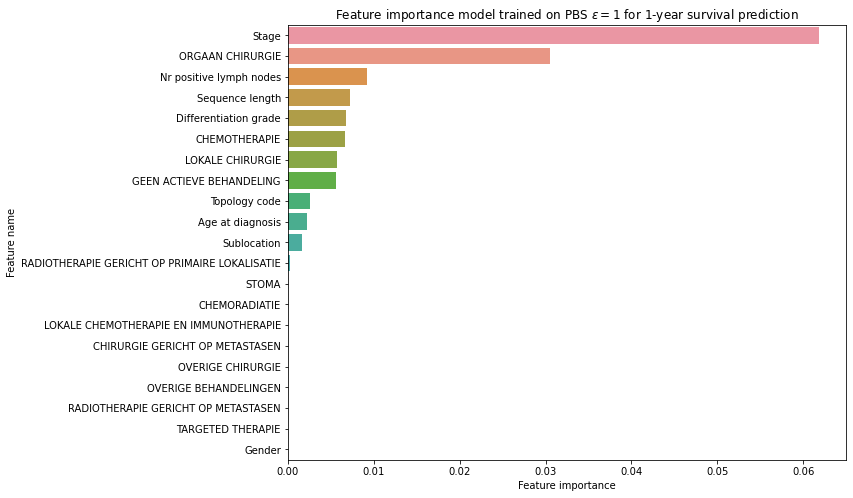

In [28]:
plot_feature_importance(qe.rf_importances_['PBS $\\varepsilon=1$']['importances_mean'], features, 'PBS $\\varepsilon=1$')

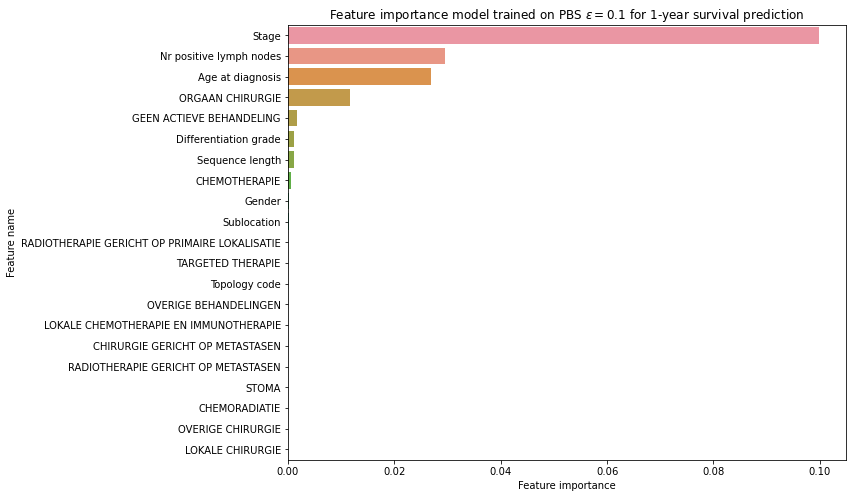

In [29]:
plot_feature_importance(qe.rf_importances_['PBS $\\varepsilon=0.1$']['importances_mean'], features, 'PBS $\\varepsilon=0.1$')

### Metric 7: Jaccard similarity Sequential Pattern Mining 

In [30]:
SPM_PATH = '../../../../../AppData/Local/conda/conda/envs/synthetic-data/Lib/site-packages'

In [31]:
qe.m7_jaccardsimilarity_SPM(spmf_bin_location_dir=SPM_PATH)

Finished SPM original
Finished SPM PBS $\varepsilon=1$
Finished SPM PBS $\varepsilon=0.1$


{'original': {'# frequent sequential patterns': 43},
 'PBS $\\varepsilon=1$': {'# frequent sequential patterns': 34,
  'intersection size': 29,
  'union size': 48,
  'jaccard similarity': 0.6041666666666666},
 'PBS $\\varepsilon=0.1$': {'# frequent sequential patterns': 141,
  'intersection size': 27,
  'union size': 157,
  'jaccard similarity': 0.17197452229299362}}

#### Robustness check

In [32]:
qe.m7_jaccardsimilarity_SPM(spmf_bin_location_dir=SPM_PATH,
                            support=0.02)

Finished SPM original
Finished SPM PBS $\varepsilon=1$
Finished SPM PBS $\varepsilon=0.1$


{'original': {'# frequent sequential patterns': 29},
 'PBS $\\varepsilon=1$': {'# frequent sequential patterns': 19,
  'intersection size': 19,
  'union size': 29,
  'jaccard similarity': 0.6551724137931034},
 'PBS $\\varepsilon=0.1$': {'# frequent sequential patterns': 16,
  'intersection size': 10,
  'union size': 35,
  'jaccard similarity': 0.2857142857142857}}

In [33]:
qe.m7_jaccardsimilarity_SPM(spmf_bin_location_dir=SPM_PATH,
                            support=0.03)

Finished SPM original
Finished SPM PBS $\varepsilon=1$
Finished SPM PBS $\varepsilon=0.1$


{'original': {'# frequent sequential patterns': 21},
 'PBS $\\varepsilon=1$': {'# frequent sequential patterns': 12,
  'intersection size': 12,
  'union size': 21,
  'jaccard similarity': 0.5714285714285714},
 'PBS $\\varepsilon=0.1$': {'# frequent sequential patterns': 5,
  'intersection size': 4,
  'union size': 22,
  'jaccard similarity': 0.18181818181818182}}